In [1]:
import os
import glob
from typing import Optional

import rasterio
import numpy as np
from tqdm import tqdm

from torch import nn
import torch.utils.data as data

In [40]:
# mapping from igbp to dfc2020 classes
DFC2020_CLASSES = [
    0,  # class 0 unused in both schemes
    1,
    1,
    1,
    1,
    1,
    2,
    2,
    3,  # --> will be masked if no_savanna == True
    3,  # --> will be masked if no_savanna == True
    4,
    5,
    6,  # 12 --> 6
    7,  # 13 --> 7
    6,  # 14 --> 6
    8,
    9,
    10
]

In [41]:
# indices of sentinel-2 high-/medium-/low-resolution bands
S2_BANDS_HR = [2, 3, 4, 8]
S2_BANDS_MR = [5, 6, 7, 9, 12, 13]
S2_BANDS_LR = [1, 10, 11]

In [42]:
# calculate number of input channels
def get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr):
    n_inputs = 0
    if use_s2hr:
        n_inputs += len(S2_BANDS_HR)
    if use_s2mr:
        n_inputs += len(S2_BANDS_MR)
    if use_s2lr:
        n_inputs += len(S2_BANDS_LR)
    if use_s1:
        n_inputs += 2
    return n_inputs

In [43]:
# select channels for preview images
def get_display_channels(use_s2hr, use_s2mr, use_s2lr):
    if use_s2hr and use_s2lr:
        display_channels = [3, 2, 1]
        brightness_factor = 3
    elif use_s2hr:
        display_channels = [2, 1, 0]
        brightness_factor = 3
    elif not (use_s2hr or use_s2mr or use_s2lr):
        display_channels = 0
        brightness_factor = 1
    else:
        display_channels = 0
        brightness_factor = 3
    return (display_channels, brightness_factor)

In [44]:
# util function for reading s2 data
def load_s2(path, use_hr, use_mr, use_lr, s2_augmentations: Optional[nn.Module] = None):
    bands_selected = []
    if use_hr:
        bands_selected = bands_selected + S2_BANDS_HR
    if use_mr:
        bands_selected = bands_selected + S2_BANDS_MR
    if use_lr:
        bands_selected = bands_selected + S2_BANDS_LR
    bands_selected = sorted(bands_selected)
    with rasterio.open(path) as data:
        s2 = data.read(bands_selected)
    s2 = s2.astype(np.float32)
    s2 = np.clip(s2, 0, 10000)
    s2 /= 10000
    s2 = s2.astype(np.float32)
    if s2_augmentations is not None:
        s2 = s2_augmentations(s2)
    return s2

# util function for reading s1 data
def load_s1(path, s1_augmentations: Optional[nn.Module] = None):
    with rasterio.open(path) as data:
        s1 = data.read()
    s1 = s1.astype(np.float32)
    s1 = np.nan_to_num(s1)
    s1 = np.clip(s1, -25, 0)
    s1 /= 25
    s1 += 1
    s1 = s1.astype(np.float32)
    if s1_augmentations is not None:
        s1 = s1_augmentations(s1)
    return s1

# util function for reading lc data
def load_lc(path, no_savanna=False, igbp=True):

    # load labels
    with rasterio.open(path) as data:
        lc = data.read(1)

    # convert IGBP to dfc2020 classes
    if igbp:
        lc = np.take(DFC2020_CLASSES, lc)
    else:
        lc = lc.astype(np.int64)

    # adjust class scheme to ignore class savanna
    if no_savanna:
        lc[lc == 3] = 0
        lc[lc > 3] -= 1

    # convert to zero-based labels and set ignore mask
    lc -= 1
    lc[lc == -1] = 255
    return lc

# util function for reading data from single sample
def load_sample(sample, use_s1, use_s2hr, use_s2mr, use_s2lr,
                no_savanna=False, igbp=True, unlabeled=False, s1_augmentations = None, s2_augmentations = None):

    use_s2 = use_s2hr or use_s2mr or use_s2lr

    # load s2 data
    if use_s2:
        img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr, s2_augmentations=s2_augmentations)

    # load s1 data
    if use_s1:
        s1_sample = load_s1(sample["s1"], s1_augmentations=s1_augmentations)
        if use_s2:
            img = np.concatenate((img, s1_sample), axis=0)
        else:
            img = s1_sample

    # load label
    if unlabeled:
        return {'image': img, 'id': sample["id"]}
    else:
        lc = load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp)
        return {'image': img, 'label': lc, 'id': sample["id"]}

In [45]:
 class DFC2020(data.Dataset):
    """PyTorch dataset class for the DFC2020 dataset"""

    def __init__(
        self,
        path,
        subset="val",
        no_savanna=False,
        use_s2hr=False,
        use_s2mr=False,
        use_s2lr=False,
        use_s1=False,
        s1_augmentations: Optional[nn.Module] = None,
        s2_augmentations: Optional[nn.Module] = None,
        batch_augmentation: Optional[nn.Module] = None,
    ):
        """Initialize the dataset"""

        # inizialize
        super(DFC2020, self).__init__()

        # make sure parameters are okay
        if not (use_s2hr or use_s2mr or use_s2lr or use_s1):
            raise ValueError("No input specified, set at least one of "
                             + "use_[s2hr, s2mr, s2lr, s1] to True!")
        self.use_s2hr = use_s2hr
        self.use_s2mr = use_s2mr
        self.use_s2lr = use_s2lr
        self.use_s1 = use_s1
        assert subset in ["val", "test"]
        self.no_savanna = no_savanna

        # store augmentations if provided
        self.s1_augmentations = s1_augmentations
        self.s2_augmentations = s2_augmentations
        self.batch_augmentation = batch_augmentation

        # provide number of input channels
        self.n_inputs = get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr)

        # provide index of channel(s) suitable for previewing the input
        self.display_channels, self.brightness_factor = get_display_channels(
                                                            use_s2hr,
                                                            use_s2mr,
                                                            use_s2lr)

        # provide number of classes
        if no_savanna:
            self.n_classes = max(DFC2020_CLASSES) - 1
        else:
            self.n_classes = max(DFC2020_CLASSES)

        # make sure parent dir exists
        assert os.path.exists(path)

        # build list of sample paths
        if subset == "val":
            path = os.path.join(path, "ROIs0000_validation", "s2_0")
        else:
            path = os.path.join(path, "ROIs0000_test", "s2_0")

        s2_locations = glob.glob(os.path.join(path, "*.tif"), recursive=True)
        self.samples = []
        for s2_loc in tqdm(s2_locations, desc="[Load]"):
            s1_loc = s2_loc.replace("_s2_", "_s1_").replace("s2_", "s1_")
            lc_loc = s2_loc.replace("_dfc_", "_lc_").replace("s2_", "dfc_")
            self.samples.append({"lc": lc_loc, "s1": s1_loc, "s2": s2_loc,
                                 "id": os.path.basename(s2_loc)})

        # sort list of samples
        self.samples = sorted(self.samples, key=lambda i: i['id'])

        print("loaded", len(self.samples),
              "samples from the dfc2020 subset", subset)

    def __getitem__(self, index):
        """Get a single example from the dataset"""

        # get and load sample from index file
        sample = self.samples[index]
        sample = load_sample(
            sample, self.use_s1, self.use_s2hr, self.use_s2mr,
            self.use_s2lr, no_savanna=self.no_savanna, igbp=False,
            s1_augmentations=self.s1_augmentations, s2_augmentations=self.s2_augmentations,
        )
        if self.batch_augmentation is not None:
            sample = self.batch_augmentation(sample)
        return sample

    def __len__(self):
        """Get number of samples in the dataset"""
        return len(self.samples)

In [205]:
print("\n\nDFC2020 validation")
data_dir = "/ds2/remote_sensing/grss-dfc-20"
ds = DFC2020(data_dir, subset="val", use_s1=True, use_s2hr=True,
             use_s2mr=True, no_savanna=True)
s = ds.__getitem__(0)
print("id:", s["id"], "\n",
      "input shape:", s["image"].shape, "\n",
      "label shape:", s["label"].shape, "\n",
      "number of classes", ds.n_classes)

print("\n\nDFC2020 test")
data_dir = "/ds2/remote_sensing/grss-dfc-20"
ds = DFC2020(data_dir, subset="test", use_s1=True, use_s2hr=True,
             use_s2mr=True, no_savanna=True)
s = ds.__getitem__(0)
print("id:", s["id"], "\n",
      "input shape:", s["image"].shape, "\n",
      "label shape:", s["label"].shape, "\n",
      "number of classes", ds.n_classes)



DFC2020 validation


[Load]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 218110.00it/s]


loaded 986 samples from the dfc2020 subset val
id: ROIs0000_validation_s2_0_p0.tif 
 input shape: (12, 256, 256) 
 label shape: (256, 256) 
 number of classes 9


DFC2020 test


[Load]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5128/5128 [00:00<00:00, 317997.41it/s]

loaded 5128 samples from the dfc2020 subset test
id: ROIs0000_test_s2_0_p0.tif 
 input shape: (12, 256, 256) 
 label shape: (256, 256) 
 number of classes 9


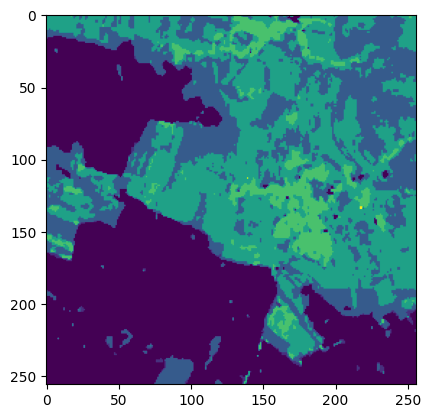

In [77]:
import matplotlib.pyplot as plt

s = ds.__getitem__(12)
plt.imshow(s["label"])

In [63]:
s = ds.__getitem__(12)

## Min-Max-Scaling Transform ##

In [193]:
from torch import nn

class TorchMinMaxScaler(nn.Module):
    def __init__(
        self,
        minimum_value: float,
        maximum_value: float,
        interval_min: float = -1.0,
        interval_max: float = 1.0,
    ):
        super().__init__()
        # Store Scaler values
        self.minimum_value = minimum_value
        self.maximum_value = maximum_value
        self.interval_min = interval_min
        self.interval_max = interval_max

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return ((x - self.minimum_value) / (self.maximum_value - self.minimum_value)) * (
            self.interval_max - self.interval_min
        ) + self.interval_min

In [200]:
rand_input = torch.rand(2, 120, 120) * -25

tmms = TorchMinMaxScaler(minimum_value=-25, maximum_value=0)
sri = tmms(rand_input)
print(sri.min(), sri.max())

tensor(-1.0000) tensor(0.9998)


## RandomCropping of input image and segmentation mask ##

In [208]:
from typing import Dict

import torch
from torchvision.transforms import RandomCrop


class RandomCropImageAndLabel(nn.Module):
    def __init__(self, img_key, label_key, *args, **kwargs):
        super().__init__()
        self.image_key = img_key
        self.label_key = label_key
        self.random_crop_op = RandomCrop(*args, **kwargs)

    def forward(self, batch: Dict[str, torch.Tensor]):
        keys = [self.image_key, self.label_key]
        assert all(x in batch.keys() for x in keys)
        img_and_label = [batch[k] for k in keys]
        img_and_label = [torch.Tensor(x) for x in img_and_label]
        for i in range(len(img_and_label)):
            if len(img_and_label[i].shape) == 2:
                img_and_label[i] = img_and_label[i].unsqueeze(dim=0)
        original_shapes = [x.shape for x in img_and_label]
        assert all(original_shapes[0][1] == s[1] for s in original_shapes)
        img_and_label = torch.concatenate(img_and_label, axis=0)
        img_and_label = self.random_crop_op(img_and_label)
        img_and_label = torch.split(img_and_label, split_size_or_sections=[s[0] for s in original_shapes], dim=0)
        
        for k, v in zip(keys, img_and_label):
            batch[k] = v
        return batch

In [174]:
s_label = s["label"]
s_img = s["image"]

In [176]:
rcm = RandomCropImageAndLabel(img_key="image", label_key="label", size=120)
reformated_s = rcm(s)

In [161]:
# Visualize pre and after

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


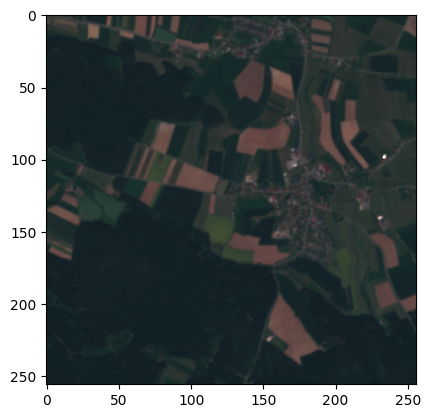

In [177]:
viz_img = np.transpose(s_img[[2, 1, 0], :, :], (1, 2, 0))
plt.imshow((viz_img / viz_img.max())*2)

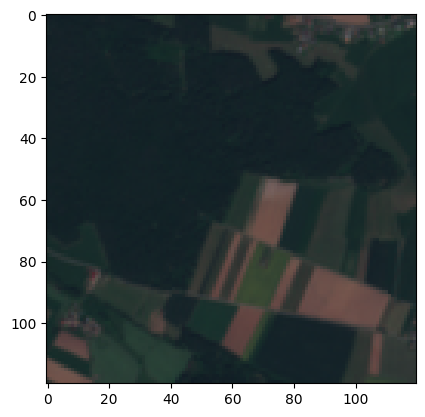

In [178]:
plt.imshow(reformated_s["image"][[2, 1, 0], :, :].permute(1, 2, 0).numpy()*2)

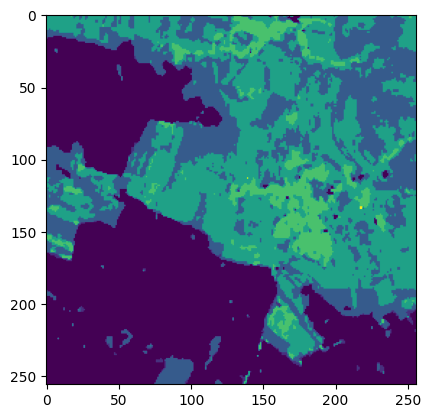

In [179]:
plt.imshow(s_label)

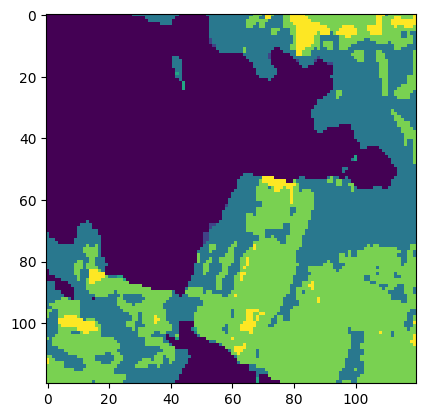

In [180]:
plt.imshow(reformated_s["label"].permute(1,2,0).detach().numpy())

## Combine Everything ##

In [2]:
ds = DFC2020(
    data_dir, 
    subset="test", 
    use_s1=True, 
    use_s2hr=True,
    use_s2mr=False, 
    no_savanna=True,
    s1_augmentations=TorchMinMaxScaler(minimum_value=-25, maximum_value=0),
    s2_augmentations=TorchMinMaxScaler(minimum_value=0, maximum_value=10000),
    batch_augmentation=RandomCropImageAndLabel(
        img_key="image",
        label_key="label",
        size=120,
    ),
)

NameError: name 'DFC2020' is not defined

In [224]:
s = ds.__getitem__(12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


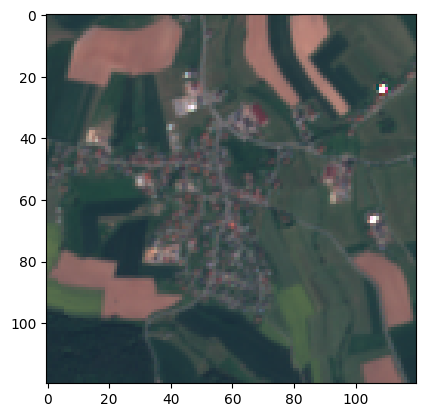

In [231]:
img = s["image"][[2, 1, 0], :, :].permute(1, 2, 0).numpy()
img = ((img + 1) / 2)
plt.imshow((img / img.max())*3)

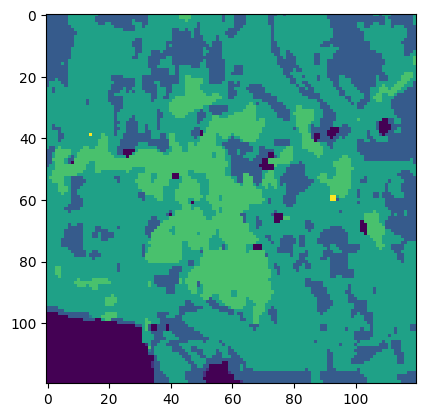

In [226]:
plt.imshow(s["label"].permute(1, 2, 0).numpy())

In [227]:
s["image"].shape

torch.Size([6, 120, 120])

In [228]:
dl = data.DataLoader(
    dataset=ds,
    batch_size=24, 
    shuffle=True,
    num_workers=4,
)

In [229]:
for batch in dl:
    break

## Pipeline setup ##

In [40]:
import yaml

import torch
import matplotlib.pyplot as plt

from lit_diffusion.util import instantiate_python_class_from_string_config
from lit_diffusion.constants import TRAIN_TORCH_DATA_LOADER_CONFIG_KEY, PYTHON_KWARGS_CONFIG_KEY, VALIDATION_TORCH_DATA_LOADER_CONFIG_KEY

In [41]:
!ls ../../config/model_configs/downstream_tasks/dfc_2020/segmentation

dfc_2020_feature_extractor-lf-1.yaml   dfc_2020_feature_extractor.yaml
dfc_2020_feature_extractor-lf-10.yaml  segmentation.yaml
dfc_2020_feature_extractor-lf-50.yaml


In [42]:
with open("../../config/model_configs/downstream_tasks/dfc_2020/segmentation/dfc_2020_feature_extractor.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

In [43]:
config[VALIDATION_TORCH_DATA_LOADER_CONFIG_KEY][PYTHON_KWARGS_CONFIG_KEY]["dataset"]

{'module': 'remote_sensing_ddpm.datasets.dfc_2020.dfc_2020.DFC2020',
 'kwargs': {'load_on_the_fly': True,
  'path': '/ds2/remote_sensing/grss-dfc-20',
  'subset': 'val',
  's2_bands': [3, 2, 1, 7],
  'use_s1': True,
  'no_snow_and_savanna': True,
  'label_dtype': 'long',
  's1_augmentations': {'module': 'remote_sensing_ddpm.datasets.dfc_2020.augmentations.min_max_scaler.TorchMinMaxScaler',
   'kwargs': {'minimum_value': 0,
    'maximum_value': 1,
    'interval_min': -1.0,
    'interval_max': 1.0}},
  's2_augmentations': {'module': 'remote_sensing_ddpm.datasets.dfc_2020.augmentations.min_max_scaler.TorchMinMaxScaler',
   'kwargs': {'minimum_value': 0,
    'maximum_value': 1,
    'interval_min': -1.0,
    'interval_max': 1.0}},
  'batch_augmentation': {'module': 'torch.nn.Sequential',
   'args': [{'module': 'remote_sensing_ddpm.datasets.dfc_2020.augmentations.transform_image_and_label.TransformImageAndLabel',
     'kwargs': {'image_key': 'image',
      'label_key': 'label',
      'transf

In [44]:
conf_ds = instantiate_python_class_from_string_config(config[VALIDATION_TORCH_DATA_LOADER_CONFIG_KEY][PYTHON_KWARGS_CONFIG_KEY]["dataset"])

[Load]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 271613.28it/s]

loaded 986 samples from the dfc2020 subset val


In [45]:
import matplotlib.pyplot as plt

def plot_single_sample(sample):
    s2_img = sample["image"][[0,1,2], :, :].permute(1, 2, 0).numpy()
    s2_img = ((s2_img + 1) / 2) * 4

    s1_vh = sample["image"][[4], :, :].permute(1, 2, 0).numpy()
    s1_vv = sample["image"][[5], :, :].permute(1, 2, 0).numpy()

    label = sample["label"].numpy()
    images = [s2_img, s1_vh, s1_vv, label]
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))

    for ax, img in zip(axs.flatten(), images):
        ax.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


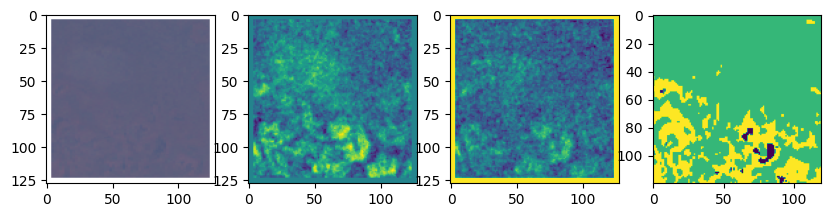

In [46]:
plot_single_sample(conf_ds[15])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


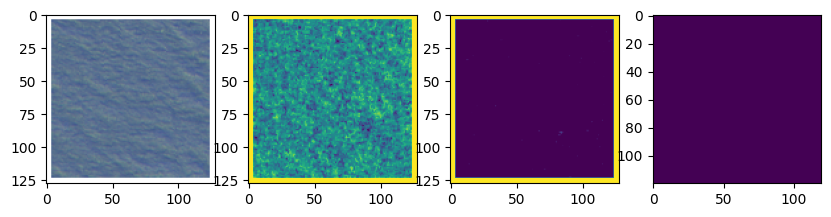

In [47]:
plot_single_sample(conf_ds[255])

## Transform Label ##

In [8]:
lc = conf_ds[5]["label"]

In [11]:
import numpy as np

def get_class_fractions_from_segmentation_map(sm: np.array, num_classes: int):
    class_fractions = np.zeros(num_classes)
    sum_count = 0
    for row in sm:
        for value in row:
            class_fractions[value] += 1
            sum_count += 1
    class_fractions /= sum_count
    return class_fractions

## Create Stratified Label Fraction Splits ##

### Pixel-based support ###

In [12]:
from tqdm import tqdm
class_distributions = np.zeros(9)
count = 0
for sample in tqdm(conf_ds):
    tmp = get_class_fractions_from_segmentation_map(sample["label"], num_classes=9)
    class_distributions += tmp
    count += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5128/5128 [07:52<00:00, 10.85it/s]


In [35]:
from tqdm import tqdm
class_distributions = np.zeros(9)
count = 0
for sample in tqdm(conf_ds):
    for row in sample["label"]:
        for value in row:
            class_distributions[value] += 1
            count += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5128/5128 [08:48<00:00,  9.69it/s]


In [36]:
for k, v in zip(["Forest", "Shrubland", "Grassland", "Wetlands", "Croplands", "Urban_Built-up", "Snow_Ice", "Barren", "Water"], class_distributions / count):
    print(f"{k}: {int(v*100)}%")

Forest: 25%
Shrubland: 5%
Grassland: 10%
Wetlands: 2%
Croplands: 19%
Urban_Built-up: 10%
Snow_Ice: 0%
Barren: 2%
Water: 23%


In [37]:
(class_distributions / count).sum()

1.0

### Majority Class-based support ###

In [16]:
from tqdm import tqdm
import torch

class_distributions = np.zeros(9)
count = 0
for sample in tqdm(conf_ds):
    label = sample["label"]
    majority_class = torch.argmax(torch.bincount(label.flatten()))
    class_distributions[majority_class] += 1
    count += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5128/5128 [14:30<00:00,  5.89it/s]


In [17]:
for k, v in zip(["Forest", "Shrubland", "Grassland", "Wetlands", "Croplands", "Urban_Built-up", "Snow_Ice", "Barren", "Water"], class_distributions / count):
    print(f"{k}: {int(v*100)}%")

Forest: 28%
Shrubland: 5%
Grassland: 6%
Wetlands: 0%
Croplands: 22%
Urban_Built-up: 10%
Snow_Ice: 1%
Barren: 23%
Water: 0%


In [48]:
import pandas as pd
majority_classes_and_id = {
    "id": [],
    "class": []
}

for i, sample in enumerate(tqdm(conf_ds)):
    id = sample["id"]
    label = sample["label"]
    majority_class = torch.argmax(torch.bincount(label.flatten()))
    majority_classes_and_id["id"].append(id)
    majority_classes_and_id["class"].append(majority_class.item())

df = pd.DataFrame(majority_classes_and_id)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [01:46<00:00,  9.27it/s]


In [49]:
df

,id,class
0,ROIs0000_validation_s2_0_p0.tif,6
1,ROIs0000_validation_s2_0_p1.tif,4
2,ROIs0000_validation_s2_0_p10.tif,0
3,ROIs0000_validation_s2_0_p100.tif,6
4,ROIs0000_validation_s2_0_p101.tif,7
...,...,...
981,ROIs0000_validation_s2_0_p982.tif,6
982,ROIs0000_validation_s2_0_p983.tif,3
983,ROIs0000_validation_s2_0_p984.tif,3
984,ROIs0000_validation_s2_0_p985.tif,7


In [50]:
fraction_samples = {}
for fraction in [0.01, 0.1, 0.5]:
    fraction_samples[fraction] = df.groupby("class").sample(frac=fraction)

In [51]:
df.to_csv("./dfc_2020_validation_classes.csv")

In [52]:
for k,v in fraction_samples.items():
    v.to_csv(f"./dfc_2020_validation_samples_fraction_{int(k*100)}.csv")

In [36]:
!pwd

/netscratch2/alontke/master_thesis/code/ssl-ddpm-rs/notebooks/data_loading


In [37]:
!ls

DFC_2020.ipynb		     dfc_2020_test_classes.csv
FFCV_Dataloading.ipynb	     dfc_2020_test_samples_fraction_1.csv
Load_ben_ge_dataset.ipynb    dfc_2020_test_samples_fraction_10.csv
Poster_Visualisations.ipynb  dfc_2020_test_samples_fraction_50.csv
activations.png		     load_data_minimal.ipynb


## Sanity Check labels ##

In [38]:
label_names = ["Unused", "Forest", "Shrubland", "Savanna", "Grassland", "Wetlands",
            "Croplands", "Urban/Built-up", "Snow/Ice", "Barren", "Water"]

In [32]:
label_names[3]

'Savanna'

In [33]:
label_names[8]

'Snow/Ice'

In [10]:
import matplotlib.pyplot as plt

import torch

def plot_single_sample(sample):
    sample["image"] = torch.Tensor(sample["image"])
    s2_img = sample["image"][[0,1,2], :, :].permute(1, 2, 0).numpy()
    s2_img = ((s2_img + 1) / 2) * 4

    s1_vh = sample["image"][[4], :, :].permute(1, 2, 0).numpy()
    s1_vv = sample["image"][[5], :, :].permute(1, 2, 0).numpy()

    label = sample["label"].numpy()
    images = [s2_img, s1_vh, s1_vv, label]
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))

    for ax, img in zip(axs.flatten(), images):
        ax.imshow(img)

In [30]:
with open("../../config/model_configs/downstream_tasks/dfc_2020/segmentation/dfc_no_snow_lj.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

conf_ds_lj = instantiate_python_class_from_string_config(config["dataset"])

[Load]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5128/5128 [00:00<00:00, 305699.29it/s]

loaded 5128 samples from the dfc2020 subset test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


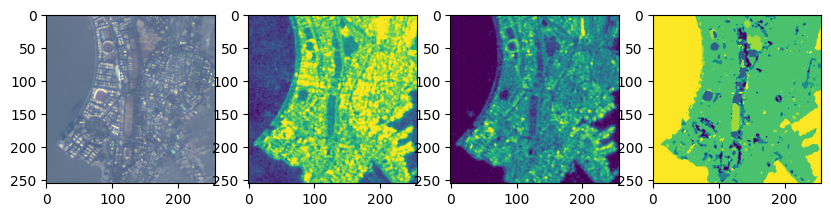

In [31]:
lj_sample = conf_ds_lj[255]
plot_single_sample(lj_sample)

In [32]:
with open("../../config/model_configs/downstream_tasks/dfc_2020/segmentation/dfc_no_snow.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

conf_ds_ns = instantiate_python_class_from_string_config(config["dataset"])

[Load]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5128/5128 [00:00<00:00, 301073.52it/s]

loaded 5128 samples from the dfc2020 subset test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


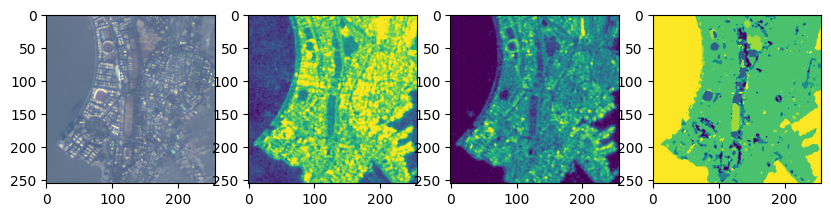

In [33]:
my_sample = conf_ds_ns[255]
plot_single_sample(my_sample)

In [22]:
LABEL_KEY = "label"
if (my_sample[LABEL_KEY] - lj_sample[LABEL_KEY]).sum() == 0:
    print("all good")

all good


In [25]:
from tqdm import tqdm

for i in tqdm(range(1000, 5128)):
    if (conf_ds_ns[i][LABEL_KEY] - conf_ds_lj[i][LABEL_KEY]).sum() != 0:
        print("alert")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4128/4128 [03:58<00:00, 17.32it/s]


In [35]:
conf_ds_ns[255][LABEL_KEY] 

tensor([[7, 7, 7,  ..., 5, 5, 5],
        [7, 7, 7,  ..., 5, 5, 5],
        [7, 7, 7,  ..., 5, 5, 5],
        ...,
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7]])

In [1]:
conf_ds_ns[255][LABEL_KEY]

NameError: name 'conf_ds_ns' is not defined

In [ ]:
from tqdm import tqdm
class_distributions = np.zeros(8)
count = 0
for sample in tqdm(conf_ds_lj):
    for row in sample["label"]:
        for value in row:
            class_distributions[value] += 1
            count += 1

 31%|██████████████████████████████████████████████████▌                                                                                                              | 1609/5128 [09:47<1:21:15,  1.39s/it]